<a href="https://colab.research.google.com/github/robertmoni/modelbasedrl/blob/master/Normal_reward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.
W0710 10:24:20.974802 139987266242432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 10:24:21.003654 139987266242432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 10:24:21.013306 139987266242432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0710 10:24:21.095882 139987266242432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0710 10:24:21.122302 13998726

--- 0 ---
episode: 0/80, score: 15, e: 0.7, action: 0
episode: 1/80, score: 8, e: 0.46, action: 0
episode: 2/80, score: 12, e: 0.25, action: 1
episode: 3/80, score: 8, e: 0.17, action: 0
episode: 4/80, score: 9, e: 0.1, action: 1
episode: 5/80, score: 8, e: 0.069, action: 1
episode: 6/80, score: 7, e: 0.048, action: 1
episode: 7/80, score: 8, e: 0.032, action: 1
episode: 8/80, score: 8, e: 0.021, action: 1
episode: 9/80, score: 9, e: 0.013, action: 1
episode: 10/80, score: 9, e: 0.0099, action: 1
episode: 11/80, score: 9, e: 0.0099, action: 1
episode: 12/80, score: 8, e: 0.0099, action: 1
episode: 13/80, score: 8, e: 0.0099, action: 1
episode: 14/80, score: 9, e: 0.0099, action: 1
episode: 15/80, score: 9, e: 0.0099, action: 1
episode: 16/80, score: 8, e: 0.0099, action: 1
episode: 17/80, score: 11, e: 0.0099, action: 1
episode: 18/80, score: 8, e: 0.0099, action: 0
episode: 19/80, score: 12, e: 0.0099, action: 0
episode: 20/80, score: 14, e: 0.0099, action: 1
episode: 21/80, score: 15

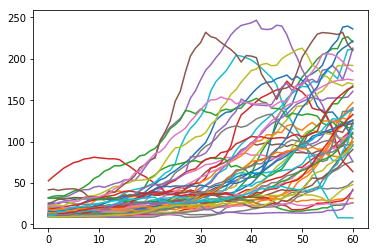

In [0]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
#%%

def build_model():
    # Neural Net for Deep-Q learning Model
    model = Sequential()
    model.add(Dense(24, input_dim=state_size, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate))
    return model

def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

def act(state, model):
    if np.random.rand() <= epsilon: # exploritaion
        return random.randrange(action_size)
    act_values = model.predict(state)
    return np.argmax(act_values[0])  # returns action

def replay(batch_size, model, epsilon, gamma):
    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            target = (reward + gamma *
                      np.amax(model.predict(next_state)[0]))
        target_f = model.predict(state)
        #if np.random.rand()<=0.1:
        #    target=target/10
        #else:
        #    target=target
        #print(target,epsilon)
            
        target_f[0][action] = target
        model.fit(state, target_f, epochs=1, verbose=0)
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    return epsilon



name = "model_dqn.hdf5"
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
EPISODES = 80
gamma = 0.95    # discount rate
epsilon_min = 0.01
epsilon_decay = 0.95
learning_rate = 0.001
# model.load_weights(name)
batch_size = 8
mstep, mscore = [], []
num_experiments = 50

#%%
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

for exp_id in range(num_experiments):
    print("---",exp_id,"---")
    epsilon = 1.0  # exploration rate
    memory = deque(maxlen=2000)
    model = build_model()
    done = False
    batch_size = 8
    minstep, maxscore = 0,0
    
    rewards = []
    
    for e in range(EPISODES):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        for time in range(500):
            #env.render()
            action = act(state,model)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -10
            next_state = np.reshape(next_state, [1, state_size])
            remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                print("episode: {}/{}, score: {}, e: {:.2}, action: {}".format(e, EPISODES, time, epsilon, action))
                rewards.append(time)
                if time>maxscore:
                    maxscore=time
                    minstep =e
                break
            if len(memory) > batch_size:
                epsilon = replay(batch_size, model, epsilon, gamma)
        # if e % 10 == 0:
        #     model.save_weights(name)
    	
    env.close()
    mstep.append(minstep)
    mscore.append(maxscore)
    print("Minstep: {}, maxscore: {} \n".format(minstep,maxscore))
    
    plt.plot(running_mean(rewards,20))
    
    
print("Max score")
print(mscore)
print("Min step")
print(mstep)


In [0]:
np.mean(mscore)

308.1

In [0]:
np.mean(mstep)

66.86